In [ ]:
0.936
[[46  0  1  0  0]
 [ 0 43  0  1  0]
 [ 0  0 49  0  0]
 [ 3  5  0 47  1]
 [ 1  2  0  2 49]]

# Pre-Trained: DenseNet

改善 CNN 模型準確率的幾種改進方法：<br>

1. data augmentation。參考 code: ex_CNN_where_am_i_augmentation.ipynb。更多的 aug: https://github.com/aleju/imgaug<br>
2. Batch Normalization, Intializer, GlobalPooling，用 GlobalPooling 取代 Dense layer，可以有效減少參數。參考 code: ex_CNN_where_am_i_advanced.ipynb<br>
3. 加深網路架構 (多疊幾層 conv，甚至使用 Residual block)、增加影像解析度 (image size 變大)、擴增網路寬度 (類似 inception 的架構)，可以參考 efficientnet 設計理念。<br>
4. learning rate 隨著迭代次數遞減 or 若 val_loss 幾次內沒有下降則降低 learning rate。參考網址: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau<br>
5. 根據資料不平衡，使用 class_weights、SMOTE、Weight Normalization 等方法。參考網址: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data<br>
6.使用較新的 activation function 取代 relu，例如 leakyrelu, swish, mish，這些 activation 可以把負值的資訊也學起來。參考網址: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation<br>

In [2]:
version = '1_2'
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# import package
import tensorflow.keras as keras
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, ReLU
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
import glob
import tensorflow as tf
from time import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
data_path = "../image_202208"

x_test_list = []
cott_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_test_list.append(os.path.join(roots, each))
            cott_list.append(each[:-4]) #檔名

In [7]:
x_test_list[1]

'../image_202208/M2208231222.png'

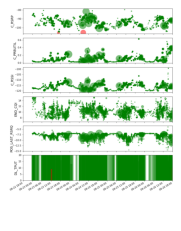

In [8]:
img = cv2.imread(x_test_list[0])[:, :, ::-1]
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
img_size = 224

In [10]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 1)
        img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])

    return np.array(data_img).astype('float32')/255.
x_test = load_img(x_test_list)

100%|██████████| 6967/6967 [01:11<00:00, 97.11it/s]


In [11]:
print(x_test.shape)

(6967, 224, 224, 3, 1)


In [12]:
x_test = np.squeeze(x_test)

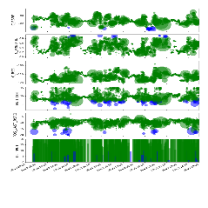

In [13]:
# show image
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(x_test[1]) #, cmap='gray'
plt.axis('off')
plt.show()

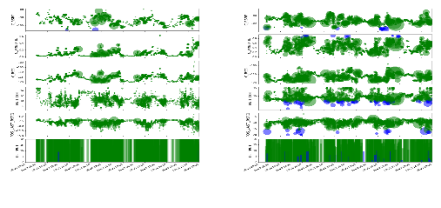

In [14]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test[i]) #[..., 0], cmap='gray'
    plt.axis('off')
plt.show()

In [15]:
from tensorflow.keras.models import Model, load_model
model = load_model('./Model/model-logs/basic_model-denseCBAM_v'+ version +'.h5')
# model = load_model('./Model/model-logs/basic_model-dense_v'+version+'.h5')

In [16]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, 1)
len(predicted)

6967

In [17]:
# 組合工單編號, 預測 reason
predict_submission = pd.DataFrame({'cott':cott_list, 'predict_reason_code': predicted})

In [18]:
predict_submission.head()

,cott,predict_reason_code
0,M2208260850,2
1,M2208231222,0
2,M2208230485,4
3,M2208180320,0
4,M2208050102,0


In [19]:
class_map = pd.read_csv('./class_mapping_v1.txt',header=None, index_col=0)
class_map = class_map.to_dict()[1]

predict_submission['predict_reason'] = predict_submission['predict_reason_code'].map(class_map).values.copy()

In [20]:
class_names = np.array([each for each in class_map.values()])
print(class_names)

['HighPRB' 'Interfere' 'NoAbnormal' 'PrbSignalNoGood' 'SignalNoGood']


In [21]:
predict_submission['predict_reason'].value_counts()

HighPRB            2889
NoAbnormal         1932
SignalNoGood       1119
PrbSignalNoGood     822
Interfere           205
Name: predict_reason, dtype: int64

## TSC

In [22]:
#取得COTT對應REASON
cott_map = pd.read_csv('../data/tsc_202208.csv',header=None, index_col=0)
cott_map = cott_map.to_dict()[1]
predict_submission['cott_reason_tsc'] = predict_submission['cott'].map(cott_map).values.copy()

In [23]:
predict_submission = predict_submission.dropna()

In [24]:
predict_submission['cott_reason_tsc'].value_counts()

SignalNoGood    1802
HighPRB          566
NoAbnormal       371
Interfere         10
Name: cott_reason_tsc, dtype: int64

In [25]:
predict_submission['predict_reason'].value_counts()

HighPRB            1156
NoAbnormal          649
SignalNoGood        486
PrbSignalNoGood     374
Interfere            84
Name: predict_reason, dtype: int64

In [26]:
predict_submission.head()

,cott,predict_reason_code,predict_reason,cott_reason_tsc
0,M2208260850,2,NoAbnormal,SignalNoGood
1,M2208231222,0,HighPRB,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB
23,M2208060411,4,SignalNoGood,NoAbnormal


## CNN & TSC (Accuracy : 0.455)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(predict_submission['predict_reason'],predict_submission['cott_reason_tsc']))
print(confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_tsc']))

# print(accuracy_score(predict_submission['predict_reason_eng'],predict_submission['cott_reason_eng']))
# print(confusion_matrix(predict_submission['predict_reason_eng'], predict_submission['cott_reason_eng']))

0.32375409239723535
[[357   3 155   0 641]
 [ 17   2  14   0  51]
 [ 80   3 138   0 428]
 [ 67   1  17   0 289]
 [ 45   1  47   0 393]]


In [28]:
matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_tsc'],
                          labels=predict_submission['predict_reason'].unique()
                    )
print(matrix)

[[138  80 428   0   3]
 [155 357 641   0   3]
 [ 47  45 393   0   1]
 [ 17  67 289   0   1]
 [ 14  17  51   0   2]]


Text(0.5, 1.0, 'Confusion Matrix')

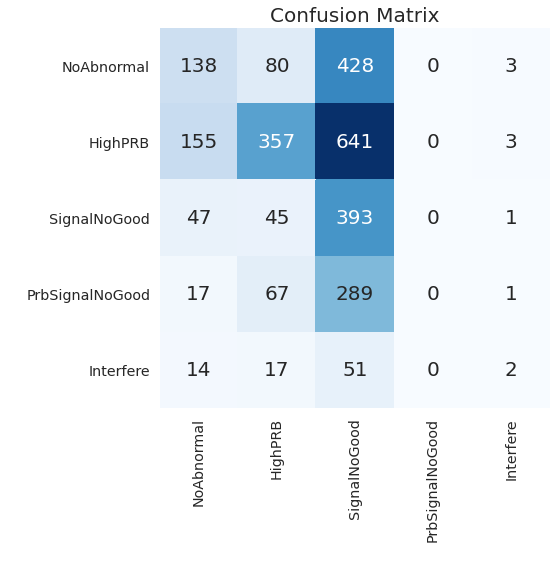

In [29]:
import seaborn as sns
# label_font = {'size':'18'}  # Adjust to fit
sns.set(font_scale=1.3) # Adjust to fit

matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_tsc'],
                          labels=predict_submission['predict_reason'].unique()
                    )
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})

sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=predict_submission['predict_reason'].unique(),
            yticklabels=predict_submission['predict_reason'].unique(),
            fmt='g')

# plt.ylabel('Predict Reason')
# plt.xlabel('COTT Reason')
plt.ylabel('   ')
plt.xlabel('  ')
plt.title('Confusion Matrix',fontsize=20)

In [30]:
predict_submission[predict_submission['cott_reason_tsc'].isin(['NoAbnormal'])].groupby(['predict_reason','cott_reason_tsc']).count()

,,cott,predict_reason_code
predict_reason,cott_reason_tsc,,
HighPRB,NoAbnormal,155,155
Interfere,NoAbnormal,14,14
NoAbnormal,NoAbnormal,138,138
PrbSignalNoGood,NoAbnormal,17,17
SignalNoGood,NoAbnormal,47,47


In [31]:
pd.set_option('display.max_rows', predict_submission.shape[0]+1)
predict_submission.head(10)

,cott,predict_reason_code,predict_reason,cott_reason_tsc
0,M2208260850,2,NoAbnormal,SignalNoGood
1,M2208231222,0,HighPRB,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB
23,M2208060411,4,SignalNoGood,NoAbnormal
28,M2208161258,0,HighPRB,SignalNoGood
31,M2208150669,4,SignalNoGood,SignalNoGood
32,M2208160302,3,PrbSignalNoGood,SignalNoGood
34,M2208260298,4,SignalNoGood,SignalNoGood
37,M2208060134,2,NoAbnormal,SignalNoGood


In [32]:
def redefine_reason(df):
    if  df['predict_reason'] == 'PrbSignalNoGood' and  df['cott_reason_tsc'] =='SignalNoGood' :
        return 'PrbSignalNoGood'
    elif  df['predict_reason'] == 'PrbSignalNoGood' and  df['cott_reason_tsc'] =='HighPRB' :
        return 'PrbSignalNoGood'
    else:
        return df['cott_reason_tsc']
    
predict_submission['cott_reason_tsc2'] = predict_submission.apply(redefine_reason, axis=1).copy()

In [33]:
print(accuracy_score(predict_submission['predict_reason'],predict_submission['cott_reason_tsc2']))
print(confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_tsc2']))

0.4532557293561295
[[357   3 155   0 641]
 [ 17   2  14   0  51]
 [ 80   3 138   0 428]
 [  0   1  17 356   0]
 [ 45   1  47   0 393]]


Text(0.5, 1.0, 'Confusion Matrix')

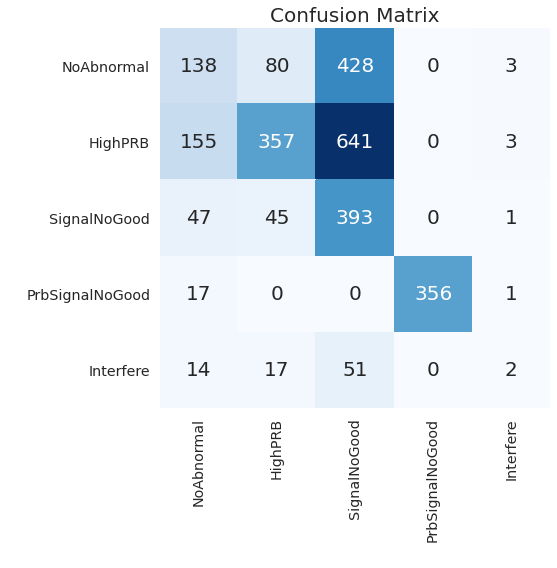

In [34]:
matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_tsc2'],
                          labels=predict_submission['predict_reason'].unique()
                    )
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})

sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=predict_submission['predict_reason'].unique(),
            yticklabels=predict_submission['predict_reason'].unique(),
            fmt='g')

# plt.ylabel('Predict Reason')
# plt.xlabel('COTT Reason')
plt.ylabel('   ')
plt.xlabel('  ')
plt.title('Confusion Matrix',fontsize=20)

In [35]:
predict_submission.head()

,cott,predict_reason_code,predict_reason,cott_reason_tsc,cott_reason_tsc2
0,M2208260850,2,NoAbnormal,SignalNoGood,SignalNoGood
1,M2208231222,0,HighPRB,SignalNoGood,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB,PrbSignalNoGood
23,M2208060411,4,SignalNoGood,NoAbnormal,NoAbnormal


In [36]:
#jupyter nbconvert --to html dense_cott_v2.ipynb

## CNN & NPSA (Accuracy:0.46)

In [37]:
cott_predict_file = pd.read_csv('../data/npsa_predict_202208.csv',header=None, index_col=0) 

In [38]:
predict_submission.head()

,cott,predict_reason_code,predict_reason,cott_reason_tsc,cott_reason_tsc2
0,M2208260850,2,NoAbnormal,SignalNoGood,SignalNoGood
1,M2208231222,0,HighPRB,SignalNoGood,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB,PrbSignalNoGood
23,M2208060411,4,SignalNoGood,NoAbnormal,NoAbnormal


In [39]:
cott_predict_file.head()

,1
0,
cott,npsa_reason
M2208311176,HighPRB
M2208311167,HighPRB
M2208311164,SignalNoGood
M2208311153,NoAbnormal


In [40]:
cott_map = cott_predict_file.to_dict()[1]

In [41]:
print(cott_map['cott'])

npsa_reason


In [42]:
#取得COTT對應REASON
cott_map = cott_predict_file.to_dict()[1]
predict_submission['cott_reason_npsa'] = predict_submission['cott'].map(cott_map).values.copy()

In [43]:
def redefine_reason_npsa(df):
    if  df['predict_reason'] == 'PrbSignalNoGood' and  df['cott_reason_npsa'] =='SignalNoGood' :
        return 'PrbSignalNoGood'
    elif  df['predict_reason'] == 'PrbSignalNoGood' and  df['cott_reason_npsa'] =='HighPRB' :
        return 'PrbSignalNoGood'
    else:
        return df['cott_reason_npsa']

In [44]:
predict_submission['cott_reason_npsa2'] = predict_submission.apply(redefine_reason_npsa, axis=1).copy()

In [45]:
predict_submission.head()

,cott,predict_reason_code,predict_reason,cott_reason_tsc,cott_reason_tsc2,cott_reason_npsa,cott_reason_npsa2
0,M2208260850,2,NoAbnormal,SignalNoGood,SignalNoGood,NoAbnormal,NoAbnormal
1,M2208231222,0,HighPRB,SignalNoGood,SignalNoGood,SignalNoGood,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal,NoAbnormal,NoAbnormal,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB,PrbSignalNoGood,SignalNoGood,PrbSignalNoGood
23,M2208060411,4,SignalNoGood,NoAbnormal,NoAbnormal,NoAbnormal,NoAbnormal


In [46]:
predict_submission = predict_submission.dropna()

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(predict_submission['predict_reason'],predict_submission['cott_reason_npsa2']))
print(confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_npsa2']))

0.4625875414670107
[[346  11 447   0 334]
 [ 13  10  24   0  33]
 [ 56   7 298   0 279]
 [  0   2  76 293   0]
 [ 49   9 118   0 308]]


Text(0.5, 1.0, 'Confusion Matrix')

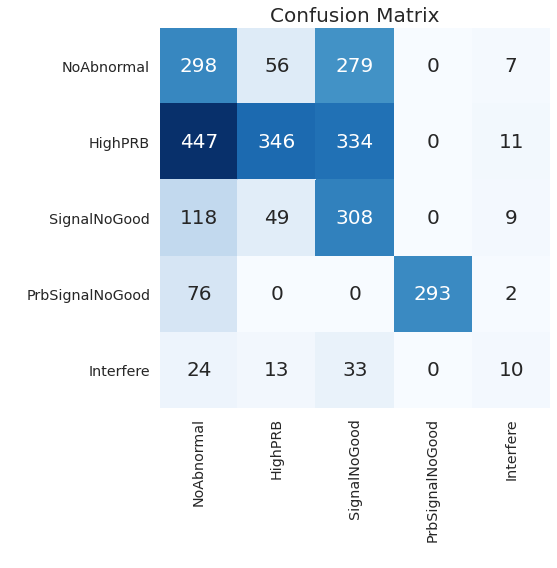

In [48]:
import seaborn as sns
matrix = confusion_matrix(predict_submission['predict_reason'], predict_submission['cott_reason_npsa2'],
                          labels=predict_submission['predict_reason'].unique()
                    )
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})

sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=predict_submission['predict_reason'].unique(),
            yticklabels=predict_submission['predict_reason'].unique(),
            fmt='g')

# plt.ylabel('Predict Reason')
# plt.xlabel('COTT Reason')
plt.ylabel('   ')
plt.xlabel('  ')
plt.title('Confusion Matrix',fontsize=20)

## TSC & NPSA (Accuracy: 0.51)

Text(0.5, 1.0, 'Confusion Matrix')

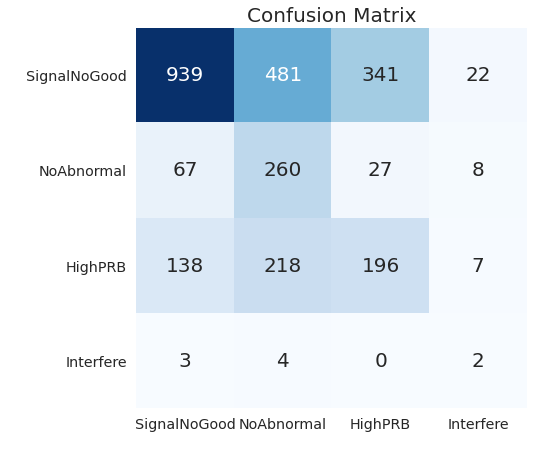

In [49]:
matrix = confusion_matrix(predict_submission['cott_reason_tsc'], predict_submission['cott_reason_npsa'],
                          labels=predict_submission['cott_reason_tsc'].unique()
                    )
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})

sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=predict_submission['cott_reason_tsc'].unique(),
            yticklabels=predict_submission['cott_reason_tsc'].unique(),
            fmt='g')

# plt.ylabel('Predict Reason')
# plt.xlabel('COTT Reason')
plt.ylabel('   ')
plt.xlabel('  ')
plt.title('Confusion Matrix',fontsize=20)

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(predict_submission['cott_reason_tsc'],predict_submission['cott_reason_npsa']))
print(confusion_matrix(predict_submission['cott_reason_tsc'], predict_submission['cott_reason_npsa']))

0.5149281238481386
[[196   7 218 138]
 [  0   2   4   3]
 [ 27   8 260  67]
 [341  22 481 939]]


In [51]:
predict_submission.head()

,cott,predict_reason_code,predict_reason,cott_reason_tsc,cott_reason_tsc2,cott_reason_npsa,cott_reason_npsa2
0,M2208260850,2,NoAbnormal,SignalNoGood,SignalNoGood,NoAbnormal,NoAbnormal
1,M2208231222,0,HighPRB,SignalNoGood,SignalNoGood,SignalNoGood,SignalNoGood
2,M2208230485,4,SignalNoGood,NoAbnormal,NoAbnormal,NoAbnormal,NoAbnormal
6,M2208170121,3,PrbSignalNoGood,HighPRB,PrbSignalNoGood,SignalNoGood,PrbSignalNoGood
23,M2208060411,4,SignalNoGood,NoAbnormal,NoAbnormal,NoAbnormal,NoAbnormal


In [52]:
predict_submission.to_csv('./predict_denseCBAM_'+today+'_v'+version+'.csv', index = False)